In [1]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +               # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" +     # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                         # chapter title ends with lowercase letters or a period
           "(.*?)" +                                     # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")                # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read().replace('&rsquo;',"'")
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&ldquo;', '"')
                                   .replace('&rdquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
# Word Count
for book in hp:
    print('{:,} words in {}'.format(sum(len(hp[book][chapter][1].split()) for chapter in hp[book]), book))
print()    
print('{:,} total words in collection'.format(sum(len(hp[book][chapter][1].split())
                                                for book in hp
                                                for chapter in hp[book])))

79,379 words in hp1
83,588 words in hp2
111,502 words in hp3
193,502 words in hp4
250,765 words in hp5
169,020 words in hp6
193,818 words in hp7

1,081,574 total words in collection


In [5]:
# Average word length
for book in hp:
    text = ''
    for chapter in hp[book]:
        text = text + hp[book][chapter][1]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), book))

5.55 Average word length in hp1
5.64 Average word length in hp2
5.65 Average word length in hp3
5.61 Average word length in hp4
5.65 Average word length in hp5
5.67 Average word length in hp6
5.66 Average word length in hp7


In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]
print(data[1])

Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys' front door; it crept into their living room, which was almost exactly the same as it had been on the night when Mr. Dursley had seen that fateful news report about the owls. Only the photographs on the mantelpiece really showed how much time had passed. Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-colored bonnets — but Dudley Dursley was no longer a baby, and now the photographs showed a large blond boy riding his first bicycle, on a carousel at the fair, playing a computer game with his father, being hugged and kissed by his mother. The room held no sign at all that another boy lived in the house, too. Yet Harry Potter was still there, asleep at the moment, but not for long. His Aunt Petu

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'the

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['mr', 'and', 'mrs_dursley', 'of', 'number_four', 'privet_drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr_dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs_dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'their', 'opinion', 

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mr', 'mrs', 'dursley', 'number', 'four', 'privet_drive', 'proud', 'say', 'perfectly', 'normal', 'thank', 'much', 'last', 'people', 'expect', 'involve', 'anything', 'strange', 'mysterious', 'hold', 'nonsense', 'mr', 'dursley', 'director', 'firm', 'call', 'grunning', 'make', 'drill', 'big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache', 'mrs', 'dursley', 'thin', 'blonde', 'nearly', 'twice', 'usual', 'amount', 'neck', 'come', 'useful', 'spend', 'much', 'time', 'crane', 'garden', 'fence', 'spy', 'neighbor', 'dursley', 'small', 'son', 'call', 'dudley', 'opinion', 'fine', 'boy', 'anywhere', 'dursley', 'everything', 'want', 'also', 'secret', 'great', 'fear', 'somebody', 'would', 'discover', 'think', 'could', 'bear', 'anyone', 'find', 'potter', 'mrs', 'potter', 'mrs', 'dursley', 'sister', 'meet', 'several', 'year', 'fact', 'mrs', 'dursley', 'pretend', 'sister', 'sister', 'good', 'nothing', 'husband', 'undursleyish', 'possible', 'dursley', 'shudder', 'think', 'neighbor', 

In [12]:
print(data_lemmatized[19])

['ron', 'breathe', 'harry', 'creep', 'window', 'pushing', 'could', 'talk', 'bar', 'ron', 'harry', 'mouth', 'fall', 'open', 'full', 'impact', 'see', 'hit', 'ron', 'lean', 'back', 'window', 'old', 'turquoise', 'car', 'park', 'midair', 'grin', 'harry', 'front', 'seat', 'fr', 'george', 'ron', 'eld', 'twin', 'brother', 'right', 'harry', 'ask', 'george', 'go', 'say', 'ron', 'answering', 'letter', 'ask', 'stay', 'twelve', 'time', 'dad', 'come', 'home', 'say', 'get', 'official', 'warning', 'use', 'magic', 'front', 'muggle', 'know', 'work', 'ministry', 'say', 'ron', 'know', 'suppose', 'spell', 'outside', 'school', 'talk', 'say', 'harry', 'star', 'float', 'car', 'oh', 'count', 'say', 'ron', 'borrow', 'dad', 'enchant', 'magic', 'front', 'muggle', 'live', 'tell', 'take', 'long', 'explain', 'look', 'tell', 'hogwart', 'dursley', 'lock', 'let', 'come', 'back', 'obviously', 'magic', 'ministry', 'think', 'second', 'spell', 'do', 'three', 'day', 'stop', 'gibber', 'say', 'ron', 'come', 'take', 'home', '-

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 3), (11, 2), (12, 5), (13, 2), (14, 2), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 1), (27, 2), (28, 1), (29, 3), (30, 1), (31, 10), (32, 3), (33, 3), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 4), (40, 2), (41, 15), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 2), (66, 1), (67, 1), (68, 2), (69, 2), (70, 4), (71, 2), (72, 5), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 1), (85, 1), (86, 9), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 9), (108, 1), (109, 3), (110, 

In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 2),
  ('able', 2),
  ('across', 2),
  ('act', 2),
  ('admire', 1),
  ('affect', 1),
  ('afternoon', 1),
  ('age', 1),
  ('agree', 1),
  ('air', 3),
  ('albus', 3),
  ('allow', 2),
  ('almost', 5),
  ('also', 2),
  ('although', 2),
  ('always', 2),
  ('amount', 1),
  ('amuse', 1),
  ('angrily', 2),
  ('angry', 1),
  ('another', 3),
  ('answer', 1),
  ('anxious', 1),
  ('anyone', 2),
  ('anything', 5),
  ('anywhere', 1),
  ('apart', 1),
  ('appear', 2),
  ('approve', 1),
  ('arm', 3),
  ('armchair', 1),
  ('around', 10),
  ('arrive', 3),
  ('ask', 3),
  ('astonishing', 1),
  ('astounding', 1),
  ('astride', 1),
  ('aunt', 2),
  ('awake', 1),
  ('away', 4),
  ('baby', 2),
  ('back', 15),
  ('bag', 1),
  ('baker', 1),
  ('bakery', 1),
  ('ball', 1),
  ('bathroom', 1),
  ('beady', 1),
  ('bear', 3),
  ('beard', 2),
  ('bed', 3),
  ('bedroom', 1),
  ('beefy', 1),
  ('behave', 1),
  ('behavior', 1),
  ('behind', 1),
  ('believe', 3),
  ('belt', 1),
  ('bend', 1),
  ('beneath', 1)

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"harry" + 0.000*"say" + 0.000*"ron" + 0.000*"look" + '
  '0.000*"dumbledore" + 0.000*"see" + 0.000*"hermione" + 0.000*"know" + '
  '0.000*"go" + 0.000*"think"'),
 (1,
  '0.036*"harry" + 0.019*"dobby" + 0.011*"say" + 0.009*"sir" + 0.008*"potter" '
  '+ 0.006*"go" + 0.006*"get" + 0.006*"look" + 0.006*"krum" + 0.006*"back"'),
 (2,
  '0.032*"harry" + 0.017*"say" + 0.011*"dumbledore" + 0.009*"know" + '
  '0.009*"wand" + 0.008*"could" + 0.007*"see" + 0.007*"look" + '
  '0.007*"voldemort" + 0.006*"back"'),
 (3,
  '0.014*"platform_nine" + 0.014*"three_quarter" + 0.012*"boy" + 0.011*"mom" + '
  '0.010*"twin" + 0.010*"train" + 0.007*"journey" + 0.007*"platform" + '
  '0.006*"boat" + 0.005*"scabber"'),
 (4,
  '0.070*"winky" + 0.058*"dobby" + 0.019*"house_elf" + 0.015*"sir" + '
  '0.011*"elf" + 0.010*"master" + 0.007*"liberation_front" + 0.006*"kitchen" + '
  '0.006*"skrewts" + 0.005*"pigwidgeon"'),
 (5,
  '0.000*"harry" + 0.000*"say" + 0.000*"ron" + 0.000*"look" + 0.000*"get" + '
  

In [17]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -7.527987725995458
Coherence Score:  0.3163702492030961


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [19]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('hermione', 0.09223193944293379),
   ('ron', 0.0709193797310208),
   ('harry', 0.05173807599029911),
   ('wand', 0.01925479532593518),
   ('goblin', 0.014257367531417653),
   ('make', 0.012787535827147792),
   ('sword', 0.011979128389799368),
   ('-PRON-', 0.011611670463731903),
   ('horcrux', 0.011170720952450945),
   ('griphook', 0.010215330344675535)]),
 (4,
  [('harry', 0.062485811577752556),
   ('back', 0.019551645856980705),
   ('voice', 0.011662883087400681),
   ('light', 0.011407491486946652),
   ('dark', 0.010839954597048809),
   ('hand', 0.009875141884222475),
   ('move', 0.009477866061293983),
   ('water', 0.008314415437003406),
   ('feel', 0.008257661748013621),
   ('make', 0.007888762769580024)]),
 (18,
  [('harry', 0.04429060592526426),
   ('dobby', 0.029477445288075034),
   ('moody', 0.027839809438737532),
   ('cedric', 0.01950275420574661),
   ('hermione', 0.018758374274229567),
   ('krum', 0.015334226589251154),
   ('mr_crouch', 0.013324400774155129),
   ('ba

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
limit=35; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 4-topic model
Calculating 6-topic model
Calculating 8-topic model
Calculating 10-topic model
Calculating 12-topic model
Calculating 14-topic model
Calculating 16-topic model
Calculating 18-topic model
Calculating 20-topic model
Calculating 22-topic model
Calculating 24-topic model
Calculating 26-topic model
Calculating 28-topic model
Calculating 30-topic model
Calculating 32-topic model
Calculating 34-topic model


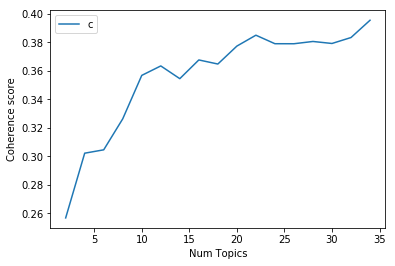

In [24]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.256797
Num Topics = 4  has Coherence Value of 0.302238
Num Topics = 6  has Coherence Value of 0.304602
Num Topics = 8  has Coherence Value of 0.326361
Num Topics = 10  has Coherence Value of 0.356861
Num Topics = 12  has Coherence Value of 0.363505
Num Topics = 14  has Coherence Value of 0.354565
Num Topics = 16  has Coherence Value of 0.367705
Num Topics = 18  has Coherence Value of 0.36484
Num Topics = 20  has Coherence Value of 0.377432
Num Topics = 22  has Coherence Value of 0.38508
Num Topics = 24  has Coherence Value of 0.379101
Num Topics = 26  has Coherence Value of 0.379082
Num Topics = 28  has Coherence Value of 0.380678
Num Topics = 30  has Coherence Value of 0.379271
Num Topics = 32  has Coherence Value of 0.383443
Num Topics = 34  has Coherence Value of 0.395579


In [26]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 5
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.065*"harry" + 0.018*"umbridge" + 0.014*"good" + 0.013*"slughorn" + '
  '0.010*"hand" + 0.009*"make" + 0.009*"snape" + 0.007*"time" + 0.007*"ginny" '
  '+ 0.007*"lsquo"'),
 (1,
  '0.094*"ron" + 0.080*"hermione" + 0.062*"harry" + 0.009*"find" + '
  '0.009*"feel" + 0.008*"make" + 0.008*"open" + 0.008*"time" + 0.007*"yeah" + '
  '0.007*"back"'),
 (2,
  '0.053*"harry" + 0.035*"voldemort" + 0.020*"wand" + 0.012*"make" + '
  '0.010*"death_eater" + 0.009*"-PRON-" + 0.008*"horcrux" + 0.008*"goblin" + '
  '0.007*"death" + 0.007*"give"'),
 (3,
  '0.025*"mrs_weasley" + 0.022*"mr_weasley" + 0.022*"harry" + 0.021*"fr" + '
  '0.017*"george" + 0.011*"wizard" + 0.010*"ginny" + 0.009*"ministry" + '
  '0.008*"percy" + 0.007*"lupin"'),
 (4,
  '0.089*"hagrid" + 0.031*"harry" + 0.020*"yeh" + 0.019*"hermione" + '
  '0.016*"ter" + 0.014*"-PRON-" + 0.013*"back" + 0.008*"forest" + 0.008*"tree" '
  '+ 0.008*"fang"'),
 (5,
  '0.062*"harry" + 0.015*"wand" + 0.013*"back" + 0.010*"foot" + 0.010*"head" + '


In [44]:
optimal_model.show_topic(0,10)

[('harry', 0.0652520391262227),
 ('umbridge', 0.01765680177505547),
 ('good', 0.01359417481796306),
 ('slughorn', 0.012500390637207412),
 ('hand', 0.01000031250976593),
 ('make', 0.009281540048126504),
 ('snape', 0.008594018563080097),
 ('time', 0.007312728522766336),
 ('ginny', 0.006718959967498985),
 ('lsquo', 0.0066877089909059655)]

In [48]:
for topic in sorted(optimal_model.show_topics(num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 1: ['ron', 'hermione', 'harry', 'find', 'feel', 'make', 'open', 'time', 'yeah', 'back']
Topic 2: ['harry', 'voldemort', 'wand', 'make', 'death_eater', '-PRON-', 'horcrux', 'goblin', 'death', 'give']
Topic 3: ['mrs_weasley', 'mr_weasley', 'harry', 'fr', 'george', 'wizard', 'ginny', 'ministry', 'percy', 'lupin']
Topic 4: ['hagrid', 'harry', 'yeh', 'hermione', 'ter', '-PRON-', 'back', 'forest', 'tree', 'fang']
Topic 5: ['harry', 'wand', 'back', 'foot', 'head', 'door', 'move', 'feel', 'face', 'light']
Topic 7: ['dumbledore', 'sirius', 'fudge', 'kreacher', 'time', 'hear', 'room', 'office', 'moment', 'black']
Topic 8: ['malfoy', 'professor_mcgonagall', 'professor', 'neville', 'student', 'class', 'table', 'ron', 'fr', 'school']
Topic 9: ['harry', 'snape', 'lupin', 'ron', 'black', 'gryffindor', 'wood', 'make', 'malfoy', 'team']
Topic 10: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'owl', 'back', 'letter', 'house', 'aunt_petunia', 'boy']
Topic 11: ['snape', 'eye', 'riddle', 'boy', 'man

In [53]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.4203,"harry, uncle_vernon, dudley, dursley, owl, bac...","Mr. and Mrs. Dursley, of number four, Privet D..."
1,1,10.0,0.5902,"harry, uncle_vernon, dudley, dursley, owl, bac...",Nearly ten years had passed since the Dursleys...
2,2,10.0,0.6082,"harry, uncle_vernon, dudley, dursley, owl, bac...",The escape of the Brazilian boa constrictor ea...
3,3,10.0,0.3802,"harry, uncle_vernon, dudley, dursley, owl, bac...",BOOM. They knocked again. Dudley jerked awake....
4,4,10.0,0.2735,"harry, uncle_vernon, dudley, dursley, owl, bac...",Harry woke early the next morning. Although he...
5,5,10.0,0.3882,"harry, uncle_vernon, dudley, dursley, owl, bac...",Harry's last month with the Dursleys wasn't fu...
6,6,8.0,0.4641,"malfoy, professor_mcgonagall, professor, nevil...","The door swung open at once. A tall, black-hai..."
7,7,8.0,0.2737,"malfoy, professor_mcgonagall, professor, nevil...","There, look."" ""Where?"" ""Next to the tall kid w..."
8,8,8.0,0.2893,"malfoy, professor_mcgonagall, professor, nevil...",Harry had never believed he would meet a boy h...
9,9,9.0,0.3238,"harry, snape, lupin, ron, black, gryffindor, w...",alfoy couldn't believe his eyes when he saw th...


In [62]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
11,11,1.0,0.2911,"ron, hermione, harry, find, feel, make, open, ...",Christmas was coming. One morning in mid-Decem...
44,44,1.0,0.2707,"ron, hermione, harry, find, feel, make, open, ...",Harry didn't have a very clear idea of how he ...
69,69,1.0,0.1970,"ron, hermione, harry, find, feel, make, open, ...",The next two days passed without great inciden...
77,77,1.0,0.3215,"ron, hermione, harry, find, feel, make, open, ...","Potter! Weasley! Will you pay attention?"" Prof..."
79,79,1.0,0.2408,"ron, hermione, harry, find, feel, make, open, ...",Everybody got up late on Boxing Day. The Gryff...
82,82,1.0,0.2161,"ron, hermione, harry, find, feel, make, open, ...",One of the best things about the aftermath of ...
84,84,1.0,0.2232,"ron, hermione, harry, find, feel, make, open, ...","It comes down to this,"" said Hermione, rubbing..."
101,101,1.0,0.1964,"ron, hermione, harry, find, feel, make, open, ...",Harry had a troubled night's sleep. His parent...
103,103,0.0,0.2853,"harry, umbridge, good, slughorn, hand, make, s...",Seamus dressed at top speed next morning and l...
104,104,0.0,0.2628,"harry, umbridge, good, slughorn, hand, make, s...",Dinner in the Great Hall that night was not a ...


In [28]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'owl,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'owl,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'owl,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'owl,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'owl,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'owl,',
  'back,',
  'letter,',
  'house,',
  'aunt_petunia,',
  'boy'],
 ['malfoy,',
  'professor_mcgonagall,',
  'professor,',
  'neville,',
  'student,',
  'class,',
  'table,',
  'ron,',
  'fr,',
  'school'],
 ['malfoy,',
  'professor_mcgonagall,',
  'professor,',
  'nev

In [29]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'owl']
1. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'owl']
2. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'owl']
3. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'owl']
4. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'owl']
5. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'owl']
6. Dominant keywords: ['malfoy', 'professor_mcgonagall', 'professor', 'neville', 'student']
7. Dominant keywords: ['malfoy', 'professor_mcgonagall', 'professor', 'neville', 'student']
8. Dominant keywords: ['malfoy', 'professor_mcgonagall', 'professor', 'neville', 'student']
9. Dominant keywords: ['harry', 'snape', 'lupin', 'ron', 'black']
10. Dominant keywords: ['harry', 'snape', 'lupin', 'ron', 'black']
11. Dominant keywords: ['ron', 'hermione', 'harry', 'find', 'feel']
12. Dominant keywords: ['harry', 'snape', 'lupin', 'ron', 'black']


In [54]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4220,"harry, umbridge, good, slughorn, hand, make, s...",Harry and Ron met Hermione in the common room ...
1,1.0,0.3215,"ron, hermione, harry, find, feel, make, open, ...","Potter! Weasley! Will you pay attention?"" Prof..."
2,2.0,0.4838,"harry, voldemort, wand, make, death_eater, -PR...","He lay facedown, listening to the silence. He ..."
3,3.0,0.3813,"mrs_weasley, mr_weasley, harry, fr, george, wi...",Harry felt as though he had barely lain down t...
4,4.0,0.5476,"hagrid, harry, yeh, hermione, ter, -PRON-, bac...",Harry sprinted up to the boys' dormitory to fe...
5,5.0,0.7296,"harry, wand, back, foot, head, door, move, fee...",Black shapes were emerging out of thin air all...
6,6.0,0.3595,"harry, moody, dobby, cedric, back, potter, kru...",You said you'd already worked out that egg clu...
7,7.0,0.5214,"dumbledore, sirius, fudge, kreacher, time, hea...",It was nearing midnight and the Prime Minister...
8,8.0,0.4641,"malfoy, professor_mcgonagall, professor, nevil...","The door swung open at once. A tall, black-hai..."
9,9.0,0.4598,"harry, snape, lupin, ron, black, gryffindor, w...","As they entered November, the weather turned v..."


In [31]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: harry, umbridge, good, slughorn, hand, make, snape, time, ginny, lsquo

Harry and Ron met Hermione in the common room before breakfast next morning. Hoping for some support for his theory, Harry lost no time in telling Hermione what he had overheard Malfoy saying on the Hogwarts Express. "But he was obviously showing off for Parkinson, wasn't he?" interjected Ron quickly, before Hermione could say anything. "Well," she said uncertainly, "I don't know. . . . It would be like Malfoy to make himself seem more important than he is . . . but that's a big lie to tell. . . ." "Exactly," said Harry, but he could not press the point, because so many people were trying to listen in to his conversation, not to mention staring at him and whispering behind their hands. "It's rude to point," Ron snapped at a particularly minuscule first-year boy as they joined the queue to climb out of the portrait hole. The boy, who had been muttering something about Harry behind his hand t

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"harry, umbridge, good, slughorn, hand, make, s...",16,0.0833
1,1.0,"ron, hermione, harry, find, feel, make, open, ...",22,0.1146
2,2.0,"harry, voldemort, wand, make, death_eater, -PR...",12,0.0625
3,3.0,"mrs_weasley, mr_weasley, harry, fr, george, wi...",16,0.0833
4,4.0,"hagrid, harry, yeh, hermione, ter, -PRON-, bac...",7,0.0365
5,5.0,"harry, wand, back, foot, head, door, move, fee...",29,0.1510
6,6.0,"harry, moody, dobby, cedric, back, potter, kru...",11,0.0573
7,7.0,"dumbledore, sirius, fudge, kreacher, time, hea...",16,0.0833
8,8.0,"malfoy, professor_mcgonagall, professor, nevil...",19,0.0990
9,9.0,"harry, snape, lupin, ron, black, gryffindor, w...",17,0.0885
